In [1]:
! pip install pyro-ppl

In [2]:
import random
import string
import os
import itertools
import torch.nn as nn
import torch
import torch.nn.functional as F
import pyro
import numpy as np
import pyro.optim as optim
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import time
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO
from PIL import Image
from torch.distributions import constraints
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.distributions.utils import probs_to_logits
from utils import *

In [3]:
pcfg = {
  "name": "astronomers",
  "terminals": ["astronomers", "ears", "saw", "stars", "telescopes", "with"],
  "non_terminals": ["S", "NP", "VP", "PP", "P", "V"],
  "productions": {
    "S": [["NP", "VP"]],
    "NP": [["NP", "PP"], ["astronomers"], ["ears"], ["saw"], ["stars"], ["telescopes"]],
    "VP": [["V", "NP"], ["VP", "PP"]],
    "PP": [["P", "NP"]],
    "P": [["with"]],
    "V": [["saw"]]
  },
  "start_symbol": "S",
}
true_production_probs = {
    "S": [1.0],
    "NP": [0.4, 0.1, 0.18, 0.04, 0.18, 0.1],
    "VP": [0.7, 0.3],
    "PP": [1.0],
    "P": [1.0],
    "V": [1.0]
}
max_depth_parse_tree = 20
slient = True
terminate_symbol = "__"

In [4]:
prior_production_logits = {
    k: torch.randn((len(v),)) 
    for k, v in pcfg['productions'].items()
}
ground_truth_production_logits = {
    k: probs_to_logits(torch.tensor(true_production_probs[k]))
    for k, v in pcfg['productions'].items()
}
if not slient:
    print(prior_production_logits)
    print(ground_truth_production_logits)

In [5]:
def generate_sentences(production_logits):
    
    def sample_parse_tree(symbol = None, depth = 0, suffix = "root"):
        if symbol is None:
            symbol = pcfg['start_symbol']
        if symbol in pcfg['terminals']:
            return symbol
        elif depth > max_depth_parse_tree:
            return terminate_symbol
        else:
            if not slient:
                print("symbol=>", symbol, production_logits[symbol])
            distribution = dist.Categorical(logits=production_logits[symbol])
            production_index = distribution.sample().detach()
            production = pcfg['productions'][symbol][production_index]
            return [symbol] + \
                [sample_parse_tree(s, depth=depth + 1, suffix = f"{suffix}_d{depth}/{i}") for i, s in enumerate(production)]
    tree = sample_parse_tree()
    if not slient:
        print("tree =>", tree)
    sentence = get_leaves(tree, max_depth_parse_tree, terminate_symbol)
    # how do we state observations, levenshtein distance?
    # may also use factor on levenshtein distance between gen and obs sentences and observe with 0

    # pad and normal distribution but very low sigma
    gen_sentence = pad_sentence(sentence_to_one_hots(sentence, pcfg["terminals"]), len(sentence))
    return sentence, gen_sentence, tree
if not slient:
    print(generate_sentences(prior_production_logits))
    print(generate_sentences(ground_truth_production_logits))

In [6]:
import model as model
import guide_obs_v5 as guide

In [7]:
if not slient:
    model.model(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [8]:
# obs_embedder_gru = nn.GRU(
#     input_size=6,
#     hidden_size=100,
#     num_layers=1
# )
obs_embedder_gru = convertion_embedding

def wrapped_guide(start_symbol='S', terminals=["astronomers", "ears", "saw", "stars", "telescopes", "with"], 
                  max_depth_parse_tree=20, terminate_symbol='__', observations={'obs': 0}):
    #print("print(observations['obs'].shape)", observations['obs'].shape)
    pyro.module('obs_embedder_gru', obs_embedder_gru)
    embedded_obs, _ = obs_embedder_gru(observations['obs'].unsqueeze(1))
    return guide.model(start_symbol, terminals, max_depth_parse_tree, terminate_symbol, {'obs' : embedded_obs[-1][0]})
if not slient:
    wrapped_guide(observations={"obs": generate_sentences(ground_truth_production_logits)[1]})

In [9]:
import tqdm
import matplotlib.pyplot as plt

In [10]:
pyro.clear_param_store()
smoke_test = False
n_steps = 10 if smoke_test else 20000
interval = 1 if smoke_test else 50
num_inference_samples = 2 if smoke_test else 10
optimiser = optim.Adam({"lr": 0.0005})
csis = pyro.infer.CSIS(model.model, wrapped_guide, optimiser, num_inference_samples=num_inference_samples)
avg_l = 0
loss_trace = []
steps = []

In [11]:
def print_weights(name, model):
    print("@params in", name)
    for param in model.parameters():
        print(param)
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [12]:
def draw_from_model(n=1000, ground_truth=True):
    logits = production_logits if not ground_truth else ground_truth_production_logits
    sample_sentences = [generate_sentences(logits) for _ in range(n)]
    return sample_sentences
sample_sentences = draw_from_model(n=n_steps)
if not slient:
    sample_sentences[0]

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n1 = count_parameters(guide._nn_merge_lhs)
n2 = count_parameters(guide._nn_model_sample_parse_tree_model_symbol)
n3 = count_parameters(guide._nn_model_sample_parse_tree_production_index_VP)
n4 = count_parameters(guide._nn_model_sample_parse_tree_production_index_NP)
n5 = count_parameters(guide._nn_tree)
n6 = count_parameters(obs_embedder_gru) # convertion_embedding
print(n1, n2, n3, n4, n5, n6, "total:", n1+n2+n3+n4+n5+n6)

20960 13920 21383 21795 14560 32400 total: 125018


  0%|                                                                                        | 0/20000 [00:00<?, ?it/s]C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_obs_v5.py:190: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_VP_params,
C:\Users\frank\OneDrive\Documents\URA\inferenceguidegen\examples\astronomers_pcfg\guide_obs_v5.py:180: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  PD.Categorical(logits=TN.LogSoftmax()(T.reshape(_production_index_NP_params,
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [2:58:52<00:00,  1.86it/s]


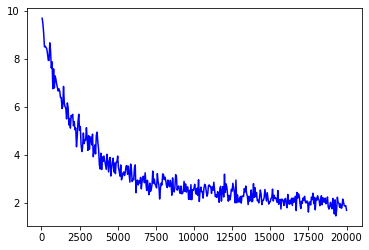

In [14]:
for step in tqdm.trange(n_steps):
    obs = sample_sentences[step]
    loss = csis.step(observations={"obs" : obs[1]})
    avg_l += loss
    if (step + 1) % interval == 0:
        steps.append(step)
        loss_trace.append(avg_l / interval)
        avg_l = 0

plt.plot(steps, loss_trace, "-b")
plt.show()

In [15]:
if not slient and smoke_test:
    print_weights("obs_embedder_gru", obs_embedder_gru)

In [16]:
def drop_paddings(sentence_tensor):
    has_values = sentence_tensor.abs().sum(dim=-1).bool()
    return sentence_tensor[has_values]
def one_hot_sentence_to_list(sentence_tensor, terminals):
    sentence_np = sentence_tensor.cpu().detach().numpy()
    sentence_indices = np.argmax(sentence_np, axis=1)
    return [terminals[i] for i in sentence_indices]

In [17]:
def test(sentences, n=1):
    num_correct_n = 0
    num_correct_all = 0
    levenshtein_distances = {}
    for i in tqdm.trange(len(sentences)):
        obs = sentences[i]
        posterior = csis.run(observations={"obs" : obs[1]})
        marginal_ret = pyro.infer.EmpiricalMarginal(posterior)
        
        for i_sample in range(n):
            
            with torch.no_grad():
                _ret = marginal_ret()

            _ret = drop_paddings(_ret)
            num_correct_n += (torch.sum(obs[1]) == torch.sum(_ret))
            num_correct_all += torch.equal(obs[1], _ret)
            lev_dis = get_levenshtein_distance(one_hot_sentence_to_list(_ret, pcfg["terminals"]), 
                                               one_hot_sentence_to_list(obs[1], pcfg["terminals"]),
                                               pcfg["terminals"])
            if lev_dis in levenshtein_distances:
                levenshtein_distances[lev_dis] += 1
            else:
                levenshtein_distances[lev_dis] = 1
    
    avg_dis = 0  
    
    for k, v in levenshtein_distances.items():
        avg_dis += k * v

    return int(num_correct_n)  / len(sentences), int(num_correct_all) / len(sentences), levenshtein_distances, avg_dis / (len(sentences) * n)

example = ["astronomers", "saw", "stars", "with", "telescopes"]
example_sentence = sentence_to_one_hots(example, pcfg["terminals"])
print("example, n=1000", test([[None, example_sentence]], n=1000))
print("examples, 1000", test([[None, example_sentence]] * 1000))
print("train", test(sample_sentences[:1000]))
test_sentences = draw_from_model(n=1000)
print("test", test(test_sentences))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


example, n=1000 (1000.0, 1000.0, {0: 1000}, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:25<00:00,  4.87it/s]


examples, 1000 (1.0, 1.0, {0: 1000}, 0.0)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:22<00:00,  1.99it/s]


train (0.824, 0.654, {11: 16, 5: 17, 0: 654, 4: 34, 12: 7, 7: 20, 9: 16, 29: 4, 8: 16, 10: 14, 3: 27, 2: 63, 1: 24, 13: 7, 6: 27, 55: 1, 31: 1, 25: 3, 16: 3, 14: 3, 15: 9, 23: 2, 21: 2, 77: 1, 19: 4, 22: 5, 17: 3, 32: 2, 26: 1, 24: 3, 45: 1, 18: 2, 51: 1, 56: 1, 38: 1, 20: 1, 36: 2, 61: 1, 33: 1}, 2.995)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:45<00:00,  1.90it/s]

test (0.812, 0.666, {0: 666, 31: 1, 6: 23, 28: 1, 5: 27, 1: 21, 3: 35, 2: 49, 9: 19, 8: 13, 15: 6, 11: 16, 30: 3, 54: 1, 13: 10, 19: 3, 12: 10, 7: 13, 16: 4, 26: 2, 4: 23, 21: 2, 18: 6, 14: 4, 34: 1, 10: 10, 29: 1, 36: 2, 42: 1, 37: 1, 20: 4, 22: 4, 32: 1, 17: 3, 23: 3, 53: 1, 48: 2, 25: 2, 38: 1, 84: 1, 39: 1, 35: 2, 27: 1}, 3.144)


In [18]:
test_sentences = draw_from_model(n=10000)
print("test", test(test_sentences))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [1:08:04<00:00,  2.45it/s]

test (0.824, 0.6869, {0: 6869, 16: 70, 9: 139, 14: 82, 2: 440, 5: 223, 1: 199, 12: 85, 8: 175, 4: 272, 15: 78, 3: 274, 28: 17, 6: 180, 11: 110, 22: 41, 19: 28, 17: 57, 13: 88, 25: 21, 10: 108, 54: 2, 34: 8, 40: 4, 27: 20, 18: 39, 7: 158, 26: 18, 56: 1, 35: 5, 24: 24, 21: 29, 36: 8, 66: 1, 29: 7, 23: 26, 20: 20, 33: 6, 38: 11, 48: 3, 51: 1, 30: 8, 46: 2, 72: 1, 61: 1, 67: 1, 43: 3, 52: 3, 37: 5, 47: 2, 55: 1, 31: 3, 57: 1, 63: 1, 41: 4, 39: 4, 32: 2, 49: 3, 71: 1, 70: 1, 64: 1, 53: 1, 42: 1, 79: 1, 97: 1, 65: 1}, 2.8705)


In [19]:
print(loss_trace)

[9.704270613789559, 9.462254586815835, 9.06961165547371, 8.51148881673813, 8.537819647789002, 8.49106249243021, 8.431531650424004, 8.224315989613533, 7.953590660989285, 7.943190951049328, 8.679314301609994, 8.348040238916873, 7.62910987764597, 7.8884710104763505, 6.767299529016018, 7.595203880891204, 6.797001544497907, 7.302760779075324, 7.161573467925191, 6.965574245117605, 6.805779430232942, 6.6687231770157815, 6.762751157749444, 6.674420047104359, 6.402517518457025, 6.399699133299291, 5.94255889561493, 6.029803442284464, 6.8624064828176055, 6.159389160876162, 6.020326838763431, 5.948572553917765, 5.511206824914552, 6.177316971467808, 5.984561176332645, 5.256176625736989, 5.528975127795711, 5.1268471083324405, 5.656817531120032, 5.599351238878444, 5.701058093090541, 5.222975361216814, 5.401852400414645, 5.057532605405431, 5.129243358225795, 4.349422452466097, 4.788801321187057, 5.410367280381033, 5.706088505889638, 5.034259914239519, 5.19505321051809, 4.442108654049807, 4.14969224665

In [20]:
print(min(loss_trace), loss_trace.index(min(loss_trace)))

1.469382154868242 385
